### Машинное Обучения

## Домашнее задание по лекции - Деревья решений

**Общая информация**

**Срок сдачи:** 2 декабря 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решение залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from collections import Counter

In [73]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def _calculate_impurity(self, y):
        match self.criterion:
            case "classification_error":
                prob = np.bincount(y) / len(y)
                return 1 - np.max(prob)
            case "gini":
                prob = np.bincount(y) / len(y)
                return 1 - np.sum(prob ** 2)
            case "entropy":
                prob = np.bincount(y) / len(y)
                return -np.sum(p * np.log2(p) for p in prob if p > 0)
            case _:
                raise ValueError("This criterion not supported")

    
    def __find_threshold_base(self, x, y):
        """
        Базовая версия
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        best_feature_id = None
        best_threshold = None
        best_ig = 0
        n_features = x.shape[1]
        h_rm = self._calculate_impurity(y)
        
        for feature_id in range(n_features):
            unique_values_by_features = np.unique(x[:, feature_id])
            
            for unique_val in unique_values_by_features:
                x_l_leaf, x_r_leaf, y_l_leaf, y_r_leaf = self.__div_samples(x, y, feature_id, unique_val)
                left_norm = len(y_l_leaf) / len(y)
                right_norm = len(y_r_leaf) / len(y)

                h_rl = self._calculate_impurity(y_l_leaf)
                h_rr = self._calculate_impurity(y_r_leaf)

                ig = h_rm -  left_norm * h_rl - right_norm * h_rr

                if ig > best_ig:
                    best_ig = ig
                    best_feature_id = feature_id
                    best_threshold = unique_val

        return best_feature_id, best_threshold, best_ig


    def _calculate_impurity_prob(self, prob):
        match self.criterion:
            case "classification_error":
                return 1 - np.max(prob)
            case "gini":
                return 1 - np.sum(prob ** 2)
            case "entropy":
                return -np.sum(p * np.log2(p) for p in prob if p > 0)
            case _:
                raise ValueError("This criterion not supported")
                

    def __find_threshold_opt(self, x, y):
        """
        Оптимизированная версия
        Находим оптимальный признак и порог для сплита
        """
        best_feature_id = None
        best_threshold = None
        best_ig = 0
        h_rm = self._calculate_impurity(y)
        n_samples, n_features = x.shape
    
        for feature_id in range(n_features):
            sorted_idx = np.argsort(x[:, feature_id])
            x_sorted = x[sorted_idx, feature_id]
            y_sorted = y[sorted_idx]

            if np.all(x[:, feature_id] == x[0, feature_id]):
                continue
            
            left_counts = np.zeros(np.max(y) + 1)
            right_counts = np.bincount(y_sorted)
    
            for i in range(1, n_samples):

                if y_sorted[i] == y_sorted[i-1]:
                    continue

                if x_sorted[i] == x_sorted[i - 1]:
                    continue

                threshold = (x_sorted[i] + x_sorted[i - 1]) / 2
                
                x_l_leaf, x_r_leaf, y_l_leaf, y_r_leaf = self.__div_samples(x, y, feature_id, threshold)
                left_norm = len(y_l_leaf) / len(y)
                right_norm = len(y_r_leaf) / len(y)

                h_rl = self._calculate_impurity(y_l_leaf)
                h_rr = self._calculate_impurity(y_r_leaf)

                ig = h_rm -  left_norm * h_rl - right_norm * h_rr

                if ig > best_ig:
                    best_ig = ig
                    best_feature_id = feature_id
                    best_threshold = (x_sorted[i] + x_sorted[i - 1]) / 2
    
        return best_feature_id, best_threshold, best_ig

    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        """
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(np.unique(y)) == 1:
            class_counts = Counter(y)
            most_common_class = class_counts.most_common(1)[0][0]
            class_prob = {cls: count / len(y) for cls, count in class_counts.items()}[most_common_class]
                
            self.tree[node_id] = (
                self.LEAF_TYPE,
                most_common_class,
                class_prob,
            )
            return

        feature_id, threshold, ig = self.__find_threshold_opt(x, y)        

        self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold, ig)
        
        x_l_leaf, x_r_leaf, y_l_leaf, y_r_leaf = self.__div_samples(x, y, feature_id, threshold)

        self.__fit_node(x_l_leaf, y_l_leaf, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r_leaf, y_r_leaf, 2 * node_id + 2, depth + 1)

    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold, _ = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self, top_n=5):
        """
        Возвращает важность признаков
        """
        feature_importance = {NODE_DATA[1]: 0 for NODE_ID, NODE_DATA in self.tree.items() if NODE_DATA[0] == self.NON_LEAF_TYPE}
        for NODE_ID, NODE_DATA in self.tree.items():
            if NODE_DATA[0] == self.NON_LEAF_TYPE:
                feature_importance[NODE_DATA[1]] += NODE_DATA[3]
        feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        if top_n:
            feature_importance = feature_importance[:top_n]
        return feature_importance

In [96]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [97]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [98]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [99]:
my_clf.fit(X_train, y_train)

In [100]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8333333333333334

In [101]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [102]:
my_clf.get_feature_importance()

[(6, np.float64(0.5154602389730563)),
 (0, np.float64(0.5)),
 (1, np.float64(0.40816326530612246)),
 (12, np.float64(0.28305849395967986)),
 (9, np.float64(0.24305469522853032))]

Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [103]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [115]:
%time clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 1.51 ms


DecisionTreeClassifier()

In [126]:
%time my_clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 15.9 ms


Получилось минимизировать через пропуск признаков, где значение y одинакое + пропускал если значение признаков одинаковые

## Боевое применение (3 балла)

Работаем с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Либо можно воспользоваться функцией:

In [282]:
def preprocess_spd_data(df):
    df = df.iloc[:, :108]
    
    to_drop = [
        'id',"iid","pid", 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 'dec', 'dec_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    columns_to_remove = df.filter(regex=r'^(attr|sinc|intel|fun|amb|shar)\d*_\d+$').columns
    df = df.drop(columns=columns_to_remove)
   
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    columns_o = [col for col in df.columns if col.endswith('_o')]

    columns_base = [col[:-2] for col in columns_o]
    
    for col_base, col_o in zip(columns_base, columns_o):
        if col_base in df.columns:
            df[f"d_{col_base}"] = abs(df[col_base] - df[col_o])
    
    return df

Скачайте датасет, обработайте данные, обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [283]:
from sklearn.metrics import roc_auc_score

In [284]:
spd_df = pd.read_csv("Speed_Dating_Data.csv", encoding="latin1")

In [285]:
prep_spd_df = preprocess_spd_data(spd_df)

In [286]:
prep_spd_df.columns

Index(['gender', 'match', 'int_corr', 'samerace', 'age_o', 'race_o',
       'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
       'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o',
       'prob_o', 'met_o', 'age', 'field_cd', 'race', 'imprace', 'imprelig',
       'goal', 'date', 'go_out', 'career_c', 'exphappy', 'attr', 'sinc',
       'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met', 'match_es',
       'd_age', 'd_race', 'd_attr', 'd_sinc', 'd_intel', 'd_fun', 'd_amb',
       'd_shar', 'd_like', 'd_prob', 'd_met'],
      dtype='object')

In [287]:
import seaborn as sns

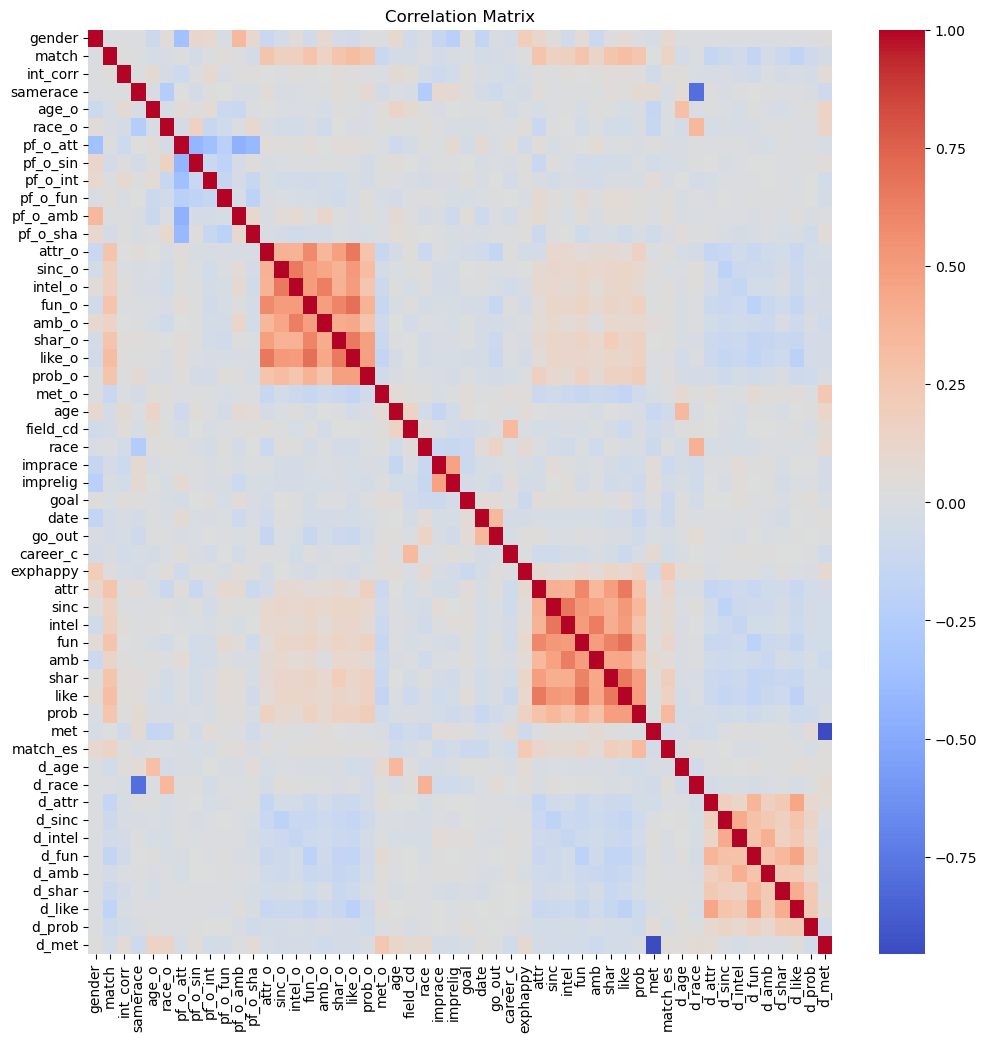

In [288]:
plt.figure(figsize=(12, 12))
sns.heatmap(prep_spd_df.corr(), fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [289]:
prep_spd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4743 entries, 0 to 8377
Data columns (total 52 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    4743 non-null   int64  
 1   match     4743 non-null   int64  
 2   int_corr  4743 non-null   float64
 3   samerace  4743 non-null   int64  
 4   age_o     4743 non-null   float64
 5   race_o    4743 non-null   float64
 6   pf_o_att  4743 non-null   float64
 7   pf_o_sin  4743 non-null   float64
 8   pf_o_int  4743 non-null   float64
 9   pf_o_fun  4743 non-null   float64
 10  pf_o_amb  4743 non-null   float64
 11  pf_o_sha  4743 non-null   float64
 12  attr_o    4743 non-null   float64
 13  sinc_o    4743 non-null   float64
 14  intel_o   4743 non-null   float64
 15  fun_o     4743 non-null   float64
 16  amb_o     4743 non-null   float64
 17  shar_o    4743 non-null   float64
 18  like_o    4743 non-null   float64
 19  prob_o    4743 non-null   float64
 20  met_o     4743 non-null   float64
 

In [290]:
prep_spd_df.describe()

,gender,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,...,d_race,d_attr,d_sinc,d_intel,d_fun,d_amb,d_shar,d_like,d_prob,d_met
count,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,...,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000
mean,0.488931,0.168880,0.194132,0.384145,26.172254,2.825216,22.571997,17.563941,20.569279,17.325773,...,1.267552,2.172739,1.787476,1.604259,1.969007,1.979970,2.119334,1.883386,2.119123,1.127135
std,0.499930,0.374686,0.304889,0.486444,3.459419,1.267984,12.149418,7.263977,7.033514,6.259110,...,1.252031,1.760313,1.492620,1.315618,1.643427,1.579344,1.691767,1.549536,1.691813,0.991777
min,0.000000,0.000000,-0.830000,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-0.020000,0.000000,24.000000,2.000000,15.000000,15.000000,17.310000,15.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,0.000000,0.000000,0.210000,0.000000,26.000000,2.000000,20.000000,18.870000,20.000000,18.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1.000000,0.000000,0.430000,1.000000,28.000000,4.000000,25.000000,20.000000,25.000000,20.000000,...,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000
max,1.000000,1.000000,0.910000,1.000000,55.000000,6.000000,100.000000,47.000000,50.000000,50.000000,...,5.000000,9.000000,10.000000,10.000000,9.000000,10.000000,9.000000,9.000000,10.000000,6.000000


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

#### Ответ: Получилось сделать модель с точностью 0.67, но есть вопрос по исходному датасету, он в конце, в разделе фитбек

In [291]:
X = prep_spd_df.drop(columns=["match"])
y = prep_spd_df["match"]

In [292]:
X_np = X.to_numpy()

In [293]:
y_np = y.to_numpy()

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, stratify=y_np)

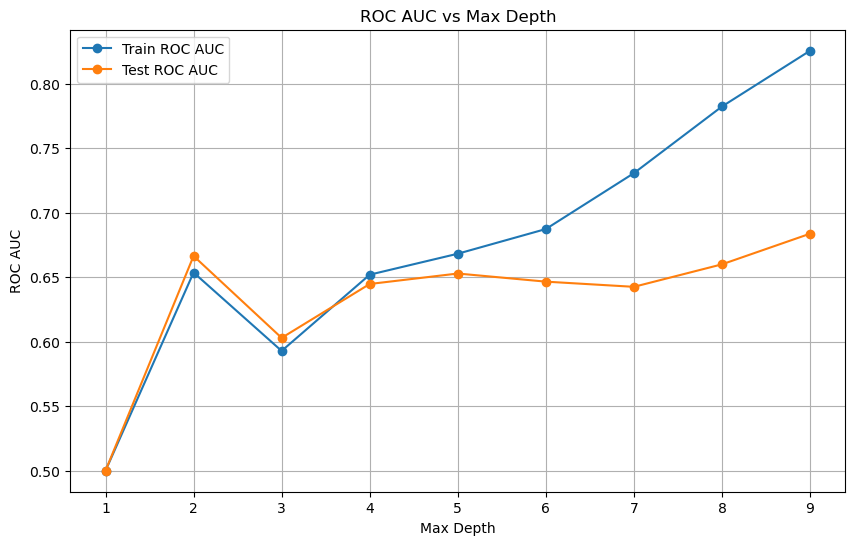

In [295]:
max_depths = range(1, 10)
train_roc_auc = []
test_roc_auc = []

for max_depth in max_depths:
    clf = MyDecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    y_train_proba = clf.predict(X_train)
    y_test_proba = clf.predict(X_test)
    
    train_roc_auc.append(roc_auc_score(y_train, y_train_proba))
    test_roc_auc.append(roc_auc_score(y_test, y_test_proba))

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_roc_auc, label="Train ROC AUC", marker='o')
plt.plot(max_depths, test_roc_auc, label="Test ROC AUC", marker='o')
plt.title("ROC AUC vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("ROC AUC")
plt.legend()
plt.grid(True)
plt.show()

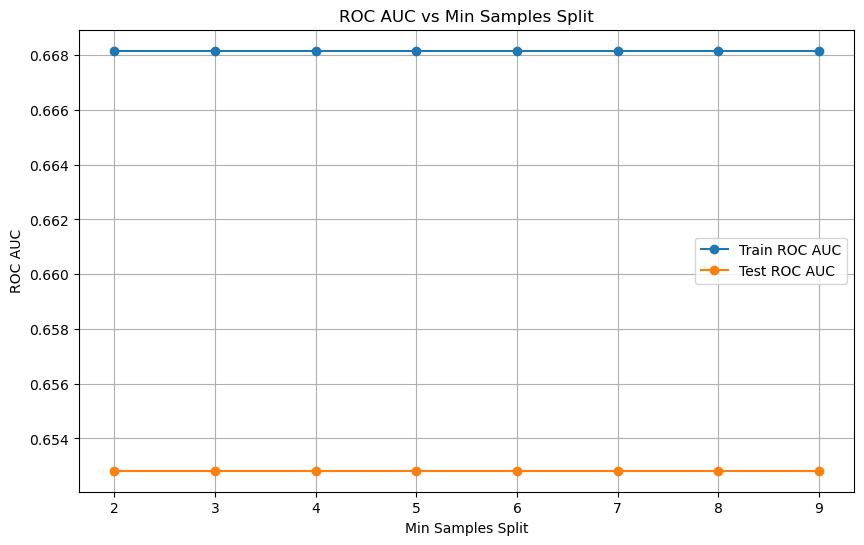

In [296]:
min_samples_splits = range(2, 10)
train_roc_auc = []
test_roc_auc = []

for min_samples_split in min_samples_splits:
    clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    
    y_train_proba = clf.predict(X_train)
    y_test_proba = clf.predict(X_test)
    
    train_roc_auc.append(roc_auc_score(y_train, y_train_proba))
    test_roc_auc.append(roc_auc_score(y_test, y_test_proba))

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(min_samples_splits, train_roc_auc, label="Train ROC AUC", marker='o')
plt.plot(min_samples_splits, test_roc_auc, label="Test ROC AUC", marker='o')
plt.title("ROC AUC vs Min Samples Split")
plt.xlabel("Min Samples Split")
plt.ylabel("ROC AUC")
plt.legend()
plt.grid(True)
plt.show()

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

#### Ответ: Да, заметил эффект от перебучения, он виден, когда при максимальной глубине 5, качество на валидационной выборке перестает расти и даже падает, это из-за переобучения модели

In [318]:
X = prep_spd_df.drop(columns=["match"])
y = prep_spd_df["match"]

In [319]:
X_np = X.to_numpy()

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, stratify=y_np)

In [321]:
clf = MyDecisionTreeClassifier(max_depth=5,min_samples_split=3)
clf.fit(X_train, y_train)

In [322]:
y_test_proba = clf.predict(X_test)

In [323]:
roc_auc_score(y_test, y_test_proba)

np.float64(0.6716135931558935)

In [303]:
clf.get_feature_importance()

[(1, np.float64(0.9356704366085782)),
 (37, np.float64(0.1229422284061703)),
 (31, np.float64(0.0832787587214428)),
 (10, np.float64(0.08278851030476272)),
 (11, np.float64(0.05501080374730419))]

In [304]:
for idx, col in enumerate(prep_spd_df.drop(columns=["match"]).columns):
    print(idx, col)

0 gender
1 int_corr
2 samerace
3 age_o
4 race_o
5 pf_o_att
6 pf_o_sin
7 pf_o_int
8 pf_o_fun
9 pf_o_amb
10 pf_o_sha
11 attr_o
12 sinc_o
13 intel_o
14 fun_o
15 amb_o
16 shar_o
17 like_o
18 prob_o
19 met_o
20 age
21 field_cd
22 race
23 imprace
24 imprelig
25 goal
26 date
27 go_out
28 career_c
29 exphappy
30 attr
31 sinc
32 intel
33 fun
34 amb
35 shar
36 like
37 prob
38 met
39 match_es
40 d_age
41 d_race
42 d_attr
43 d_sinc
44 d_intel
45 d_fun
46 d_amb
47 d_shar
48 d_like
49 d_prob
50 d_met


## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [305]:
clf = MyDecisionTreeClassifier(max_depth=5, min_samples_split=5)

In [306]:
clf.fit(X_train, y_train)

In [307]:
y_pred = clf.predict(X_test)

In [308]:
roc_auc_score(y_test, y_pred)

np.float64(0.638506020278834)

In [309]:
clf.get_feature_importance(top_n=2)

[(1, np.float64(0.49122599216413376)), (37, np.float64(0.1229422284061703))]

In [310]:
for idx, col in enumerate(prep_spd_df.drop(columns=["match"]).columns):
    print(idx, col)

0 gender
1 int_corr
2 samerace
3 age_o
4 race_o
5 pf_o_att
6 pf_o_sin
7 pf_o_int
8 pf_o_fun
9 pf_o_amb
10 pf_o_sha
11 attr_o
12 sinc_o
13 intel_o
14 fun_o
15 amb_o
16 shar_o
17 like_o
18 prob_o
19 met_o
20 age
21 field_cd
22 race
23 imprace
24 imprelig
25 goal
26 date
27 go_out
28 career_c
29 exphappy
30 attr
31 sinc
32 intel
33 fun
34 amb
35 shar
36 like
37 prob
38 met
39 match_es
40 d_age
41 d_race
42 d_attr
43 d_sinc
44 d_intel
45 d_fun
46 d_amb
47 d_shar
48 d_like
49 d_prob
50 d_met


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Все понятно, спасибо за лекцию

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

Есть вопрос по датасету и насколько тут уместна в датасете dec и dec_o - решение человека и решение партнера соот-но, т.к. это основные признаки, которые в принципе будут влиять на результат модели, т.к. разница значений между ними и есть колонка match

In [337]:
def preprocess_spd_new_data(df):
    df = df.iloc[:, :108]
    
    to_drop = [
        'id',"iid","pid", 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', # убрал dec dec_0
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    columns_to_remove = df.filter(regex=r'^(attr|sinc|intel|fun|amb|shar)\d*_\d+$').columns
    df = df.drop(columns=columns_to_remove)
   
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    columns_o = [col for col in df.columns if col.endswith('_o')]

    columns_base = [col[:-2] for col in columns_o]
    
    for col_base, col_o in zip(columns_base, columns_o):
        if col_base in df.columns:
            df[f"d_{col_base}"] = abs(df[col_base] - df[col_o])
    
    return df

In [338]:
spd_df = pd.read_csv("Speed_Dating_Data.csv", encoding="latin1")

In [339]:
prep_spd_df = preprocess_spd_new_data(spd_df)

In [340]:
prep_spd_df

,gender,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,...,d_dec,d_attr,d_sinc,d_intel,d_fun,d_amb,d_shar,d_like,d_prob,d_met
0,0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,...,1,0.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,0.0
1,0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,...,1,0.0,0.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0
3,0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,...,0,0.0,2.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0
4,0,1,0.21,0,24.0,3.0,30.0,10.0,20.0,10.0,...,0,3.0,1.0,2.0,1.0,3.0,1.0,2.0,0.0,0.0
5,0,0,0.25,0,25.0,2.0,50.0,0.0,30.0,10.0,...,1,3.0,2.0,1.0,4.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8367,1,0,0.37,0,28.0,6.0,25.0,15.0,25.0,15.0,...,0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
8368,1,0,0.27,1,26.0,2.0,10.0,30.0,20.0,15.0,...,1,6.0,3.0,1.0,4.0,4.0,2.0,3.0,0.0,2.0
8369,1,0,0.45,1,22.0,2.0,10.0,20.0,15.0,20.0,...,1,5.0,6.0,0.0,1.0,3.0,1.0,1.0,1.5,2.0
8370,1,0,0.35,0,27.0,4.0,10.0,25.0,20.0,20.0,...,1,5.0,5.0,3.0,3.0,1.0,5.0,1.0,4.0,2.0


In [341]:
X = prep_spd_df.drop(columns=["match"])
y = prep_spd_df["match"]

In [342]:
X_np = X.to_numpy()

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, stratify=y_np)

In [344]:
clf = MyDecisionTreeClassifier(max_depth=5,min_samples_split=3)
clf.fit(X_train, y_train)

In [345]:
y_test_proba = clf.predict(X_test)

In [346]:
roc_auc_score(y_test, y_test_proba)

np.float64(1.0)

#### Если тут нет противоречий, то тогда лучший результат по метрике: 1

### ВАШ ОТЗЫВ ЗДЕСЬ



Было бы очень интересно, если бы после каждой домашки был семинар или хотя бы файл с итоговым решением от преподавателя, чтобы мы могли понять как мыслит человек с опытом при решение такого рода задач, особенно было бы интересно посмотреть на процесс EDA, т.к. он как будто бы один из самых важных